In [1]:
import pandas as pd
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import datetime
import numpy as np
from IPython import display

In [2]:
import sys
print(sys.version)

2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]


In [3]:
import matplotlib
matplotlib.__version__

'2.0.2'

In [4]:
widgets.__version__

'6.0.0'

In [5]:
pd.__version__

u'0.20.3'

In [6]:
np.__version__

'1.13.1'

In [8]:
import scipy
scipy.__version__

'0.17.1'

In [ ]:
basemap.__version__

In [9]:
df = pd.read_csv('./data_for_week77.csv')
del df['Unnamed: 0']
df['hour_id'] = pd.to_datetime(df['date']).apply(lambda(x): (x-datetime.datetime(2016,5,31,23,0,0)).days*24+(x-datetime.datetime(2016,5,31,23,0,0)).seconds/3600)

target = pd.read_csv('./target (1).csv')
target = target.loc[pd.to_datetime(target.datetime)>=datetime.datetime(2016,6,1,0,0,0),:]
target['hour_id'] = pd.to_datetime(target['datetime']).apply(lambda(x): (x-datetime.datetime(2016,5,31,23,0,0)).days*24+(x-datetime.datetime(2016,5,31,23,0,0)).seconds/3600)
target = pd.DataFrame(binned_statistic_2d(target.hour_id,
                            target['region'], 
                            target['trips'], 
                            'sum', 
                            bins=[range(721), range(1,2502)]).statistic, columns=range(1,2501), 
                        index = [datetime.datetime(2016,6,1,0,0,0)+datetime.timedelta(hours=x) for x in range(720)])

def prepare_prediction(hour_number):
    a = binned_statistic_2d(df.hour_id,
                            df['region'], 
                            df['h{}'.format(hour_number)], 
                            'sum', 
                            bins=[range(716), range(1,2502)])
    return pd.DataFrame(a.statistic, columns=range(1,2501), 
                        index = [datetime.datetime(2016,5,31,23,0,0)+datetime.timedelta(hours=x) for x in range(715)])

pred1 = prepare_prediction(1)
pred2 = prepare_prediction(2)
pred3 = prepare_prediction(3)
pred4 = prepare_prediction(4)
pred5 = prepare_prediction(5)
pred6 = prepare_prediction(6)

# задаём константы
longitude_start = -74.25559
longitude_end = -73.70001
latitude_start = 40.49612
latitude_end = 40.91553
nbins = 50
longitude_step = (longitude_end - longitude_start)/nbins
latitude_step = (latitude_end - latitude_start)/nbins

def myplot(hour):
    display.clear_output()
    print(hour)
    # рисуем статическую карту
    
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(18, 14))

    ax = fig.add_subplot(nrows, ncols, 1)
    m = Basemap(llcrnrlon=longitude_start,llcrnrlat=latitude_start,urcrnrlon=longitude_end,urcrnrlat=latitude_end, projection='merc',epsg=2263, resolution='c')
    m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
   
    # задаём сетку
    x, y = np.mgrid[slice(longitude_start, longitude_end+longitude_step/2, longitude_step),
                    slice(latitude_start, latitude_end+latitude_step/2, latitude_step)]
    # задаём значения 
    z = pred1.loc[pred1.index==hour,:].values[0]
    i=0
    zz=[]
    while i<len(z):
      zz.append(z[i:i+nbins])
      i+=nbins
    # раскрашиваем ячейки
    m.pcolormesh (x, y, zz, latlon=True, cmap='OrRd', alpha=0.7)
    plt.colorbar()
    
    
    ax = fig.add_subplot(nrows, ncols, 2)
    m = Basemap(llcrnrlon=longitude_start,llcrnrlat=latitude_start,urcrnrlon=longitude_end,urcrnrlat=latitude_end, projection='merc',epsg=2263, resolution='c')
    m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)

    # задаём сетку
    x, y = np.mgrid[slice(longitude_start, longitude_end+longitude_step/2, longitude_step),
                    slice(latitude_start, latitude_end+latitude_step/2, latitude_step)]
    # задаём значения 
    z = target.loc[target.index==datetime.datetime.strftime(datetime.datetime.strptime(hour, '%Y-%m-%d %H:%M:%S') + datetime.timedelta(hours=1), '%Y-%m-%d %H:%M:%S'),:].values[0]
    i=0
    zz=[]
    while i<len(z):
      zz.append(z[i:i+nbins])
      i+=nbins
    # раскрашиваем ячейки
    m.pcolormesh (x, y, zz, latlon=True, cmap='OrRd', alpha=0.7)
    plt.colorbar()
    
    plt.show()
    
class DateRangePicker(object):
    def __init__(self,start,freq='D',fmt='%Y-%m-%d'):
        self.date_range=pd.date_range(start=start,end=datetime.datetime.strptime('2016-06-30 17:00:00', '%Y-%m-%d %H:%M:%S'),freq=freq)
        options = [(item.strftime(fmt),item) for item in self.date_range]
        self.slider_start = widgets.SelectionSlider(
            description='start',
            options=options,
            continuous_update=False
        )

        self.slider_start.on_trait_change(self.slider_start_changed, 'value')

        self.widget = widgets.Box(children=[self.slider_start])

    def slider_start_changed(self,key,value):
        self.slider_start.value=min(self.slider_start.value,datetime.datetime.strptime('2016-06-30 17:00:00', '%Y-%m-%d %H:%M:%S'))
        self._observe(hour=datetime.datetime.strftime(self.slider_start.value, '%Y-%m-%d %H:%M:%S'))

    def display(self):
        display.display(self.slider_start)

    def _observe(self,**kwargs):
        if hasattr(self,'observe'):
            self.observe(**kwargs)    

# Карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени

Нужно запустить ячейку ниже. Появится ползунок. Двигая ползунок, можно изменять час, для которого строится предсказание и реальные значения. Графики строятся при изменении часа. Слева предсказываемые значения, справа реальные. Отрисовывает медленно, нужно подождать. Указаны данные за июнь 2016 года.

2016-06-10 13:00:00
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=913163.164603,120130.315144,1067162.39182,272972.57121&bboxSR=2263&imageSR=2263&size=1500,1488&dpi=96&format=png32&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=913163.164603,120130.315144,1067162.39182,272972.57121&bboxSR=2263&imageSR=2263&size=1500,1488&dpi=96&format=png32&f=image


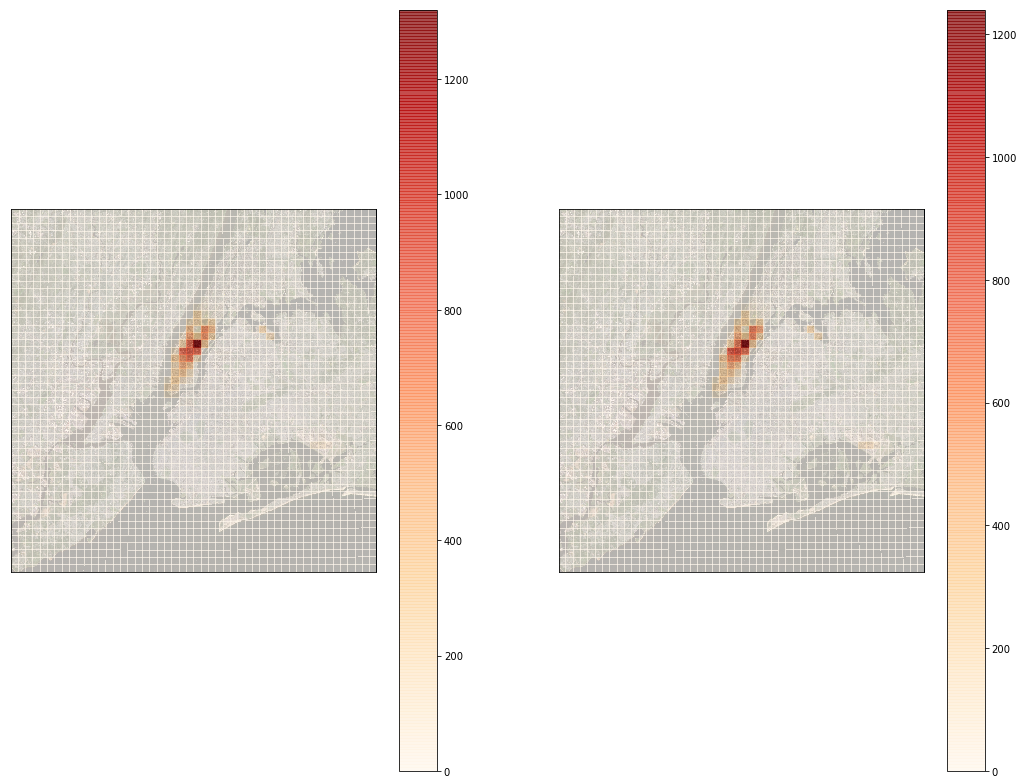

In [10]:
w=DateRangePicker(start='2016-05-31 23:00:00',freq='H',fmt='%Y-%m-%d %H:%M:%S')
w.observe=myplot
w.display()


# Временной ряд фактического и прогнозируемого спроса на такси в выбираемой области
Вводим номер региона, смотрим предсказание и реальные значения ряда на июнь 2016 года. Изначально показывается график за весь июнь. Можно двигать значения start и end, чтобы посмотреть поближе интересующие интервалы. Значения start и end меняются от 0 до 720 -- количество часов в июне. Получаемые datetime выводятся над графиком. Если выбрать start>end, ничего не отобразится.

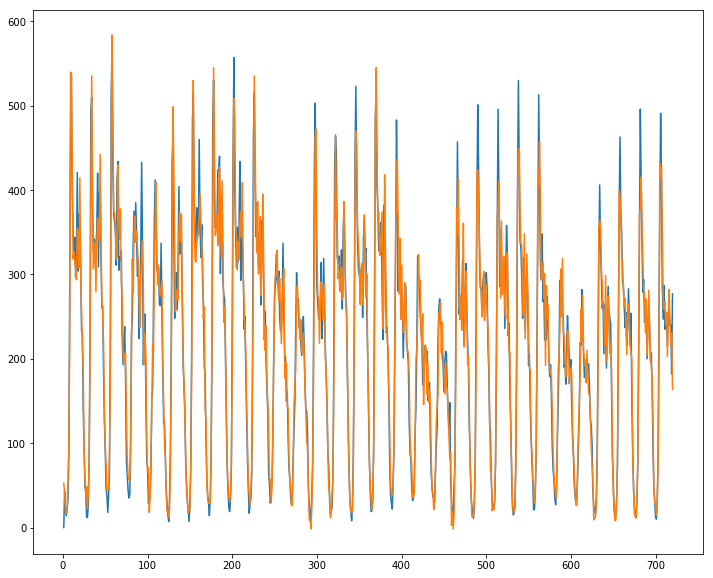

<function __main__.myplot2>

In [91]:
def myplot2(region, start, end):
    print('Showing dates: from {} to {}'.format(datetime.datetime.strftime(
        datetime.datetime(2016,6,1,0,0,0,0)+datetime.timedelta(hours=start),'%Y-%m-%d %H:%M:%S'),
                                               datetime.datetime.strftime(
        datetime.datetime(2016,6,1,0,0,0,0)+datetime.timedelta(hours=end),'%Y-%m-%d %H:%M:%S')))
    pred = list(pred1.ix[:,region].values)
    pred.append(pred2.ix[714,region])
    pred.append(pred3.ix[714,region])
    pred.append(pred4.ix[714,region])
    pred.append(pred5.ix[714,region])    
    pred.append(pred6.ix[714,region])    
    plt.figure(figsize=(12,10))
    plt.plot(range(start, end), target.ix[:,region][start:end])
    plt.plot(range(start, end), pred[start:end])
    plt.show()
    
interact(myplot2, 
         region = widgets.SelectionSlider(
                options=[1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
                                          1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
                                          1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
                                          1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
                                          1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
                                          1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
                                          1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
                                          1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
                                          1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
                                          2118, 2119, 2168],
                value=1385,
                description='region',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True),
         start = widgets.IntSlider(min=0,max=714,step=1,value=0),
         end = widgets.IntSlider(min=0,max=719,step=1,value=719)
        )